<a href="https://colab.research.google.com/github/chethankotian2005/INTERNSHIP/blob/main/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tourism Behavior Clustering

Tourism generates massive amounts of data from bookings, spending, trip durations, and traveler preferences. However, understanding this data and identifying distinct types of tourists is challenging using traditional methods.

In this project, we apply unsupervised machine learning to cluster tourists into meaningful groups based on their behavior, such as luxury travelers, budget seekers, adventure enthusiasts, or family-oriented tourists.

By analyzing features like trip duration, number of destinations, activities, spending patterns, and seasonality, the model uncovers hidden patterns that can help:
Travel agencies personalize packages,
Hospitality providers improve customer experience, and
Tourism boards design better promotional strategies.


## Project Overview


| Field | Description |
|---|---|
| **Project Title** | Tourism Behavior Clustering |
| **Domain** | Travel & Tourism / Hospitality |
| **Data Type** | Tabular — bookings, trips, spending, activities, demographics |
| **ML Techniques** | Unsupervised learning: PCA, t-SNE (visualization), KMeans, Hierarchical; Hyperparameter tuning with GridSearchCV |
| **Preprocessing Required** | Missing value imputation, feature engineering (e.g., spend_per_destination), categorical encoding (One-Hot), scaling (StandardScaler), outlier flagging |
| **Dimensionality Reduction** | PCA (for variance retention and speed), t-SNE (for visualization) |
| **Clustering Method** | KMeans (primary), Agglomerative Hierarchical (dendrogram + supplementary) |
| **Evaluation Metrics** | Elbow (inertia), Silhouette Score, Davies–Bouldin Index, cluster sizes and human-interpretable profiles |
| **Final Output** | Labeled dataset (clusters + descriptive labels), model artifacts (.joblib), reports and visualizations |
| **Tools & Libraries** | Python, pandas, numpy, scikit-learn, matplotlib, plotly, scipy, joblib |


In [3]:
# Cell: imports & settings
import os, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
warnings.filterwarnings('ignore')
np.random.seed(42)

print('Environment ready. Python:', sys.version.split('\n')[0])
os.makedirs('outputs', exist_ok=True)


Environment ready. Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [2]:
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/Datasets/tourism_behavior_analysis_updated_data.xlsx"
df_raw = pd.read_excel(FILE_PATH)

print("Loaded file:", FILE_PATH)
print("Shape:", df_raw.shape)
display(df_raw.head())

os.makedirs("outputs", exist_ok=True)
df_raw.to_csv("outputs/raw_uploaded.csv", index=False)
print("Saved a CSV copy to outputs/raw_uploaded.csv")

Loaded file: /content/drive/MyDrive/Colab Notebooks/Datasets/tourism_behavior_analysis_updated_data.xlsx
Shape: (1000, 15)


,Tourist_ID,Country,Age,Gender,Travel_Purpose,Preferred_Destination,Stay_Duration_Days,Spending_USD,Accommodation_Type,Travel_Frequency_per_Year,Average_Spending_Accommodation_USD,Average_Spending_Transport_USD,Average_Spending_Food_USD,Average_Cost_Per_Day_AED,With_Family
0,T0001,France,33,Male,Medical,Beach,8,3024,Hotel,3,293,103,35,5041.995085,Without Family
1,T0002,Canada,58,Female,Business,Beach,27,2469,Hostel,6,258,79,141,1559.226171,Without Family
2,T0003,Canada,35,Other,Education,City,16,684,Resort,1,328,266,176,2510.978323,With Family
3,T0004,UK,39,Other,Leisure,Adventure Park,3,880,Hotel,8,479,228,110,2362.073069,With Family
4,T0005,France,49,Male,Leisure,Beach,10,654,Airbnb,5,331,121,194,1393.362935,Without Family


Saved a CSV copy to outputs/raw_uploaded.csv


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Cell: Column mapping helper
# Inspect columns and update `manual_map` if needed.
display(list(df_raw.columns))

# Map original dataset columns to pipeline expected names (edit manual_map accordingly)
manual_map = {
    'Age': 'age',
    'Country': 'country',
    'Stay_Duration_Days': 'trip_duration_days',
    # 'orig_dest_count': 'num_destinations', # Not in data, will use default
    # 'orig_month': 'season', # Not in data, will use default
    'Travel_Purpose': 'travel_purpose',
    'Accommodation_Type': 'accommodation',
    # 'orig_activities': 'activities_count', # Not in data, will use default
    'Spending_USD': 'total_spend',
    'Average_Cost_Per_Day_AED': 'avg_daily_spend' # Using AED as a proxy, may need conversion
}

df = df_raw.rename(columns=manual_map).copy()

# Create reasonable defaults/placeholders for missing expected columns
if 'age' not in df.columns: df['age'] = np.random.randint(18,70,size=len(df))
if 'country' not in df.columns: df['country'] = 'Unknown'
# Fixed: Ensure a Series is returned before calling fillna
if 'trip_duration_days' not in df.columns:
    df['trip_duration_days'] = df.get('nights', df.get('length_of_stay', pd.Series([3]*len(df)))).fillna(3).astype(int)

if 'num_destinations' not in df.columns: df['num_destinations'] = 1
if 'season' not in df.columns: df['season'] = 'peak'
if 'travel_purpose' not in df.columns: df['travel_purpose'] = 'leisure'
if 'accommodation' not in df.columns: df['accommodation'] = 'midrange'
if 'activities_count' not in df.columns: df['activities_count'] = 0
if 'total_spend' not in df.columns:
    price_col = next((c for c in df.columns if 'price' in c.lower() or 'cost' in c.lower() or 'amount' in c.lower()), None)
    if price_col is not None:
        df['total_spend'] = df[price_col].fillna(df[price_col].median()) * df['trip_duration_days']
    else:
        df['total_spend'] = np.clip(np.random.normal(200,150,size=len(df))*df['trip_duration_days'], 10, None)
if 'avg_daily_spend' not in df.columns:
    df['avg_daily_spend'] = df['total_spend'] / df['trip_duration_days']

print('Mapped & prepared columns preview:')
display(df[['age','country','trip_duration_days','num_destinations','season','travel_purpose','accommodation','activities_count','total_spend','avg_daily_spend']].head())

df.to_csv('outputs/mapped_loaded.csv', index=False)
print('Saved mapped copy to outputs/mapped_loaded.csv')

['Tourist_ID',
 'Country',
 'Age',
 'Gender',
 'Travel_Purpose',
 'Preferred_Destination',
 'Stay_Duration_Days',
 'Spending_USD',
 'Accommodation_Type',
 'Travel_Frequency_per_Year',
 'Average_Spending_Accommodation_USD',
 'Average_Spending_Transport_USD',
 'Average_Spending_Food_USD',
 'Average_Cost_Per_Day_AED',
 'With_Family']

Mapped & prepared columns preview:


,age,country,trip_duration_days,num_destinations,season,travel_purpose,accommodation,activities_count,total_spend,avg_daily_spend
0,33,France,8,1,peak,Medical,Hotel,0,3024,5041.995085
1,58,Canada,27,1,peak,Business,Hostel,0,2469,1559.226171
2,35,Canada,16,1,peak,Education,Resort,0,684,2510.978323
3,39,UK,3,1,peak,Leisure,Hotel,0,880,2362.073069
4,49,France,10,1,peak,Leisure,Airbnb,0,654,1393.362935


Saved mapped copy to outputs/mapped_loaded.csv


# Cell: Cleaning & basic preprocessing

In [6]:
# Fill missing country with mode
if df['country'].isna().sum() > 0:
    df['country'] = df['country'].fillna(df['country'].mode()[0])

# Ensure numeric columns are numeric and fill NA with median
numeric_cols = ['age','trip_duration_days','num_destinations','activities_count','total_spend','avg_daily_spend']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())

# Impute total_spend if any remain
if df['total_spend'].isna().sum() > 0:
    mask = df['total_spend'].isna()
    if 'avg_daily_spend' in df.columns and 'trip_duration_days' in df.columns:
        df.loc[mask,'total_spend'] = df.loc[mask,'avg_daily_spend'] * df.loc[mask,'trip_duration_days']
    df['total_spend'] = df['total_spend'].fillna(df['total_spend'].median())

# Recompute avg_daily_spend for consistency
df['avg_daily_spend'] = df['total_spend'] / df['trip_duration_days']

# Remove duplicates
before = len(df)
df = df.drop_duplicates()
print('Removed duplicates:', before - len(df))

# Outlier flagging using z-score
z = np.abs(stats.zscore(df[numeric_cols].fillna(df[numeric_cols].median())))
df['outlier_flag'] = (z > 3).any(axis=1).astype(int)
print('Outlier count:', int(df['outlier_flag'].sum()))

df.to_csv('outputs/cleaned.csv', index=False)
print('Saved cleaned data to outputs/cleaned.csv')

Removed duplicates: 0
Outlier count: 29
Saved cleaned data to outputs/cleaned.csv


# Cell: Feature engineering

In [7]:
df_fe = df.copy()
df_fe['spend_per_destination'] = (df_fe['total_spend'] / df_fe['num_destinations']).replace([np.inf,-np.inf], np.nan).fillna(df_fe['total_spend'])
df_fe['is_peak_season'] = (df_fe['season'].astype(str).str.lower() == 'peak').astype(int)
df_fe['is_family_trip'] = df_fe['travel_purpose'].astype(str).str.contains('family', case=False, na=False).astype(int)
df_fe['is_business_trip'] = df_fe['travel_purpose'].astype(str).str.contains('business', case=False, na=False).astype(int)
df_fe['is_adventure_trip'] = df_fe['travel_purpose'].astype(str).str.contains('adventure', case=False, na=False).astype(int)

top_countries = df_fe['country'].value_counts().nlargest(6).index.tolist()
df_fe['country_cat'] = df_fe['country'].apply(lambda x: x if x in top_countries else 'Other')

preview_cols = ['age','country','trip_duration_days','num_destinations','season','travel_purpose','accommodation','activities_count','total_spend','avg_daily_spend','spend_per_destination']
print('Feature-engineered preview:')
display(df_fe[preview_cols].head())

df_fe.to_csv('outputs/fe.csv', index=False)
print('Saved feature-engineered data to outputs/fe.csv')

Feature-engineered preview:


,age,country,trip_duration_days,num_destinations,season,travel_purpose,accommodation,activities_count,total_spend,avg_daily_spend,spend_per_destination
0,33,France,8,1,peak,Medical,Hotel,0,3024,378.000000,3024.0
1,58,Canada,27,1,peak,Business,Hostel,0,2469,91.444444,2469.0
2,35,Canada,16,1,peak,Education,Resort,0,684,42.750000,684.0
3,39,UK,3,1,peak,Leisure,Hotel,0,880,293.333333,880.0
4,49,France,10,1,peak,Leisure,Airbnb,0,654,65.400000,654.0


Saved feature-engineered data to outputs/fe.csv


# Cell: Exploratory Data Analysis (matplotlib)

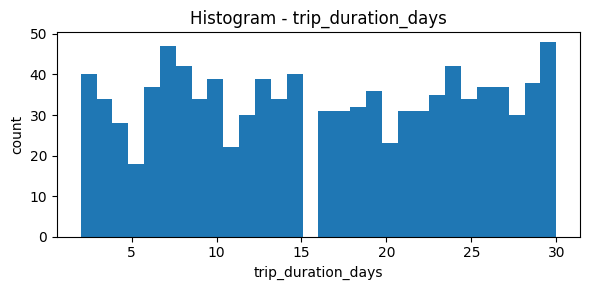

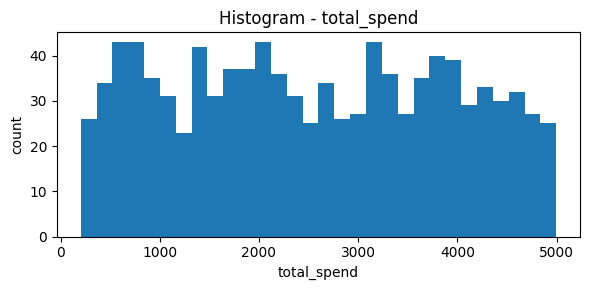

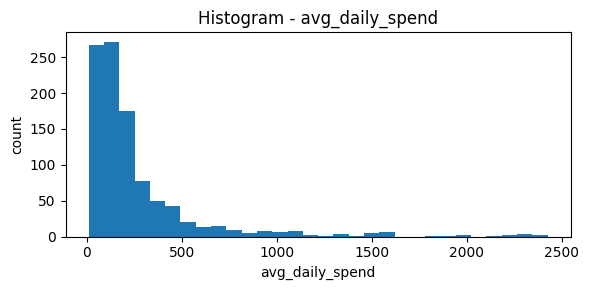

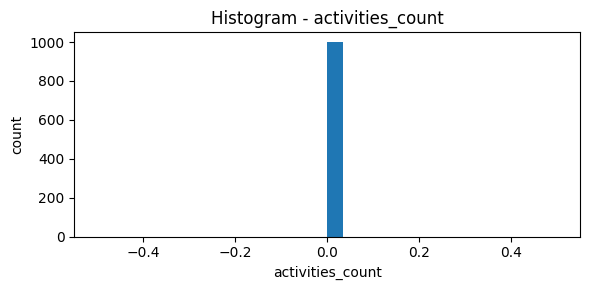

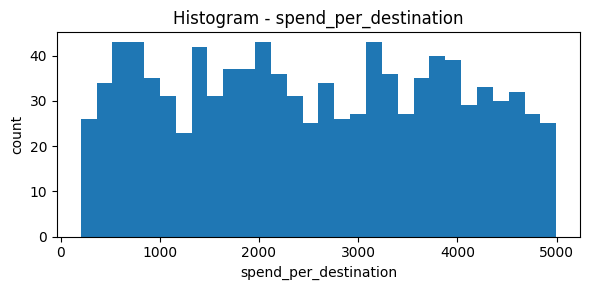

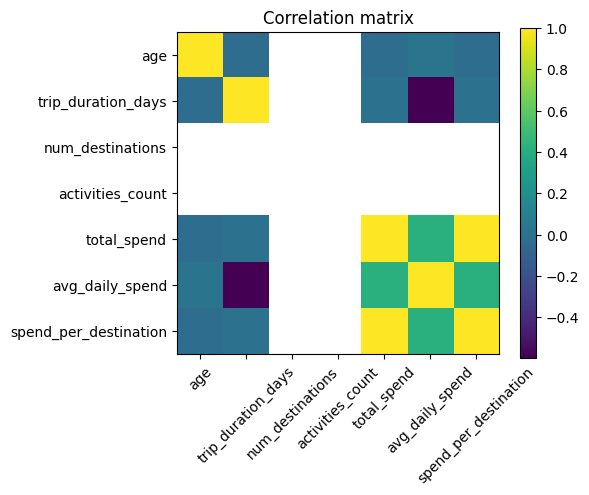

In [8]:
plot_cols = ['trip_duration_days','total_spend','avg_daily_spend','activities_count','spend_per_destination']
for c in plot_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df_fe[c], bins=30)
    plt.title(f'Histogram - {c}'); plt.xlabel(c); plt.ylabel('count'); plt.tight_layout(); plt.show()

numeric = ['age','trip_duration_days','num_destinations','activities_count','total_spend','avg_daily_spend','spend_per_destination']
corr = df_fe[numeric].corr()
plt.figure(figsize=(6,5)); plt.imshow(corr); plt.colorbar(); plt.xticks(range(len(corr)), corr.columns, rotation=45); plt.yticks(range(len(corr)), corr.columns); plt.title('Correlation matrix'); plt.tight_layout(); plt.show()

# Cell: Preprocessing - One-Hot encoding & Scaling

In [11]:
cat_cols = ['accommodation','country_cat']
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
cat_arr = ohe.fit_transform(df_fe[cat_cols].astype(str))
cat_names = ohe.get_feature_names_out(cat_cols)
df_cat = pd.DataFrame(cat_arr.toarray(), columns=cat_names, index=df_fe.index) # Convert to dense array


feature_numeric = ['age','trip_duration_days','num_destinations','activities_count','total_spend','avg_daily_spend','spend_per_destination']
flag_cols = ['is_peak_season','is_family_trip','is_business_trip','is_adventure_trip']

features = pd.concat([df_fe[feature_numeric], df_cat, df_fe[flag_cols]], axis=1)
features = features.fillna(features.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
print('Prepared feature matrix shape:', X_scaled.shape)

Prepared feature matrix shape: (1000, 20)


# Cell: PCA - explained variance and transform

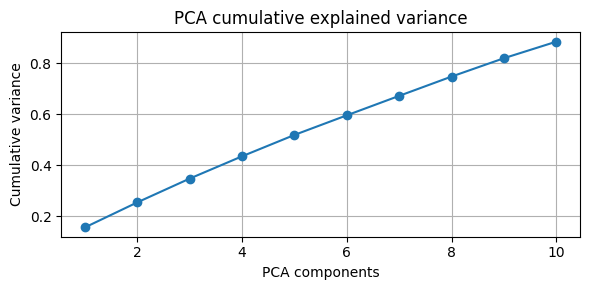

Selected PCA n_components: 3
X_pca shape: (1000, 3)


In [12]:
pca_temp = PCA(n_components=min(10, X_scaled.shape[1]))
pca_temp.fit(X_scaled)
explained = pca_temp.explained_variance_ratio_
cum = np.cumsum(explained)

plt.figure(figsize=(6,3)); plt.plot(range(1,len(explained)+1), cum, marker='o'); plt.xlabel('PCA components'); plt.ylabel('Cumulative variance'); plt.title('PCA cumulative explained variance'); plt.grid(True); plt.tight_layout(); plt.show()

n_comp = int(np.searchsorted(cum, 0.90) + 1) if cum[-1] >= 0.90 else min(3, X_scaled.shape[1])
n_comp = max(2, n_comp)
print('Selected PCA n_components:', n_comp)

pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)
print('X_pca shape:', X_pca.shape)

# Cell: t-SNE (sampled for speed)

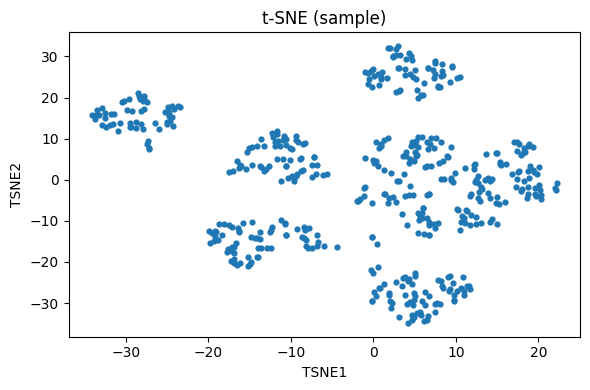

In [13]:
sample_size = min(500, X_scaled.shape[0])
sample_idx = np.random.choice(range(X_scaled.shape[0]), size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42, n_iter=750)
X_tsne_sample = tsne.fit_transform(X_sample)

plt.figure(figsize=(6,4)); plt.scatter(X_tsne_sample[:,0], X_tsne_sample[:,1], s=12); plt.title('t-SNE (sample)'); plt.xlabel('TSNE1'); plt.ylabel('TSNE2'); plt.tight_layout(); plt.show()

# Cell: Elbow and Silhouette for k in 2..10

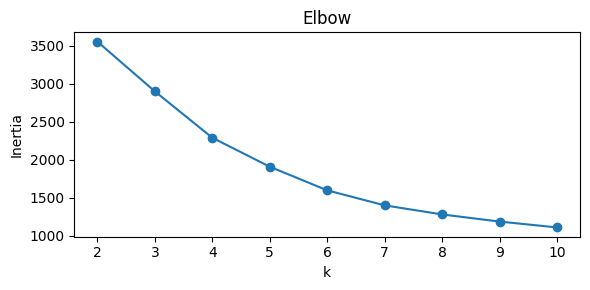

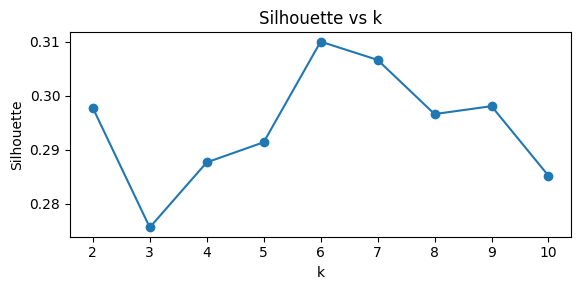

Best k by silhouette: 6 silhouette: 0.3100501738487729


In [14]:
ks = list(range(2,11))
inertias = []; sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))

plt.figure(figsize=(6,3)); plt.plot(ks, inertias, marker='o'); plt.title('Elbow'); plt.xlabel('k'); plt.ylabel('Inertia'); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,3)); plt.plot(ks, sil_scores, marker='o'); plt.title('Silhouette vs k'); plt.xlabel('k'); plt.ylabel('Silhouette'); plt.tight_layout(); plt.show()

best_k = ks[int(np.argmax(sil_scores))]
print('Best k by silhouette:', best_k, 'silhouette:', max(sil_scores))

# Cell: GridSearchCV tuning (PCA components + KMeans k)

In [15]:
pipeline = Pipeline([('pca', PCA()), ('kmeans', KMeans(random_state=42, n_init=10))])
param_grid = {'pca__n_components': [max(2, min(10, X_pca.shape[1]//2)), min(3, X_pca.shape[1]), min(5, X_pca.shape[1])], 'kmeans__n_clusters': [2,3,4,5,6]}

def silhouette_scorer(estimator, X):
    Xt = estimator.named_steps['pca'].fit_transform(X)
    labels = estimator.named_steps['kmeans'].fit_predict(Xt)
    return silhouette_score(Xt, labels)

grid = GridSearchCV(pipeline, param_grid, scoring=silhouette_scorer, cv=3, n_jobs=-1, verbose=0)
print('Running GridSearchCV (this may take a little while)...')
grid.fit(X_scaled)
print('Grid best params:', grid.best_params_, 'best silhouette:', grid.best_score_)

Running GridSearchCV (this may take a little while)...
Grid best params: {'kmeans__n_clusters': 3, 'pca__n_components': 2} best silhouette: 0.38805411647791505


# Cell: Final fit & evaluation

Final clustering -> k=3, pca_comp=2, Silhouette=0.385, DBI=0.909


,count
cluster,
0,214
1,452
2,334


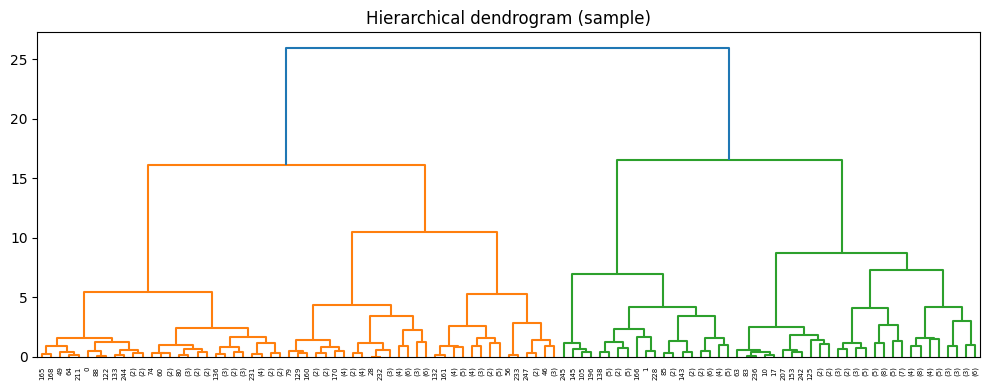

In [16]:
best_pca_comp = grid.best_params_['pca__n_components']
best_k = grid.best_params_['kmeans__n_clusters']

pca_final = PCA(n_components=best_pca_comp)
X_pca_final = pca_final.fit_transform(X_scaled)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_final = kmeans_final.fit_predict(X_pca_final)

df_fe = df_fe.reset_index(drop=True)
df_fe['cluster'] = labels_final

sil_final = silhouette_score(X_pca_final, labels_final)
dbi_final = davies_bouldin_score(X_pca_final, labels_final)
print(f'Final clustering -> k={best_k}, pca_comp={best_pca_comp}, Silhouette={sil_final:.3f}, DBI={dbi_final:.3f}')
display(df_fe['cluster'].value_counts().sort_index())

# Hierarchical dendrogram (sample)
sample_idx2 = np.random.choice(range(X_pca_final.shape[0]), size=min(250, X_pca_final.shape[0]), replace=False)
Z = linkage(X_pca_final[sample_idx2], method='ward')
plt.figure(figsize=(10,4)); dendrogram(Z, truncate_mode='level', p=6); plt.title('Hierarchical dendrogram (sample)'); plt.tight_layout(); plt.show()

# Cell: Visualize clusters (PCA + t-SNE sample colored)

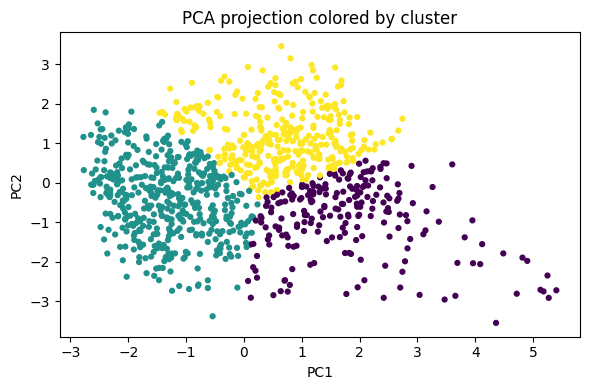

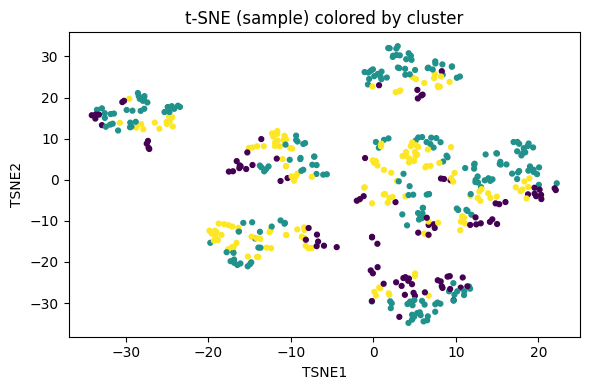

In [17]:
if X_pca_final.shape[1] >= 2:
    plt.figure(figsize=(6,4)); plt.scatter(X_pca_final[:,0], X_pca_final[:,1], c=labels_final, s=12); plt.title('PCA projection colored by cluster'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.tight_layout(); plt.show()

labels_sample = df_fe.loc[sample_idx, 'cluster'].values
plt.figure(figsize=(6,4)); plt.scatter(X_tsne_sample[:,0], X_tsne_sample[:,1], c=labels_sample, s=12); plt.title('t-SNE (sample) colored by cluster'); plt.xlabel('TSNE1'); plt.ylabel('TSNE2'); plt.tight_layout(); plt.show()

# Cell: Centroids (approx) and cluster profiles

In [18]:
centroids_pca = kmeans_final.cluster_centers_
centroids_scaled = pca_final.inverse_transform(centroids_pca)
centroids_orig = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids_orig, columns=features.columns)
print('Cluster centroids (approx):'); display(centroid_df.round(2))

profile_cols = ['trip_duration_days','total_spend','avg_daily_spend','activities_count','num_destinations']
cluster_profiles = df_fe.groupby('cluster')[profile_cols].mean().round(2)
cluster_profiles['size'] = df_fe['cluster'].value_counts().sort_index().values
print('Cluster profiles:'); display(cluster_profiles)

Cluster centroids (approx):


,age,trip_duration_days,num_destinations,activities_count,total_spend,avg_daily_spend,spend_per_destination,accommodation_Hostel,accommodation_Hotel,accommodation_Resort,country_cat_China,country_cat_France,country_cat_Germany,country_cat_India,country_cat_Other,country_cat_UK,is_peak_season,is_family_trip,is_business_trip,is_adventure_trip
0,46.62,8.71,1.0,0.0,3660.16,649.60,3660.16,0.03,0.45,0.32,0.13,0.23,0.05,0.10,0.23,0.13,1.0,0.0,0.17,0.0
1,47.28,16.78,1.0,-0.0,1312.40,95.12,1312.40,0.20,0.28,0.29,0.14,0.13,0.11,0.16,0.22,0.10,1.0,0.0,0.24,0.0
2,46.79,20.31,1.0,0.0,3486.24,241.23,3486.24,0.44,0.08,0.23,0.10,0.04,0.23,0.09,0.26,0.17,1.0,0.0,0.26,0.0


Cluster profiles:


,trip_duration_days,total_spend,avg_daily_spend,activities_count,num_destinations,size
cluster,,,,,,
0,8.52,3613.02,677.58,0.0,1.0,214
1,16.76,1292.98,109.34,0.0,1.0,452
2,20.46,3542.73,204.06,0.0,1.0,334


In [19]:
# Cell: Heuristic labels & recommendations
labels_map = {}
for idx, row in cluster_profiles.iterrows():
    if row['total_spend'] > df_fe['total_spend'].quantile(0.75):
        labels_map[idx] = 'Luxury/High-spend'
    elif row['avg_daily_spend'] < df_fe['avg_daily_spend'].quantile(0.25):
        labels_map[idx] = 'Budget/Low-daily-spend'
    elif row['activities_count'] > df_fe['activities_count'].median():
        labels_map[idx] = 'Active/Adventure-oriented'
    else:
        labels_map[idx] = 'Moderate/Leisure'

df_fe['cluster_label'] = df_fe['cluster'].map(labels_map)
print('Assigned labels:'); display(pd.Series(labels_map))

print('\nRecommendations:')
for label in set(labels_map.values()):
    if 'Luxury' in label:
        print('- {}: Offer premium packages and concierge services.'.format(label))
    elif 'Budget' in label:
        print('- {}: Promote budget bundles and discounts.'.format(label))
    elif 'Active' in label:
        print('- {}: Promote adventure packages and activities.'.format(label))
    else:
        print('- {}: Promote family-friendly & leisure packages.'.format(label))

display(df_fe[['age','country','trip_duration_days','total_spend','activities_count','cluster','cluster_label']].head(12))

Assigned labels:


,0
0,Moderate/Leisure
1,Moderate/Leisure
2,Moderate/Leisure



Recommendations:
- Moderate/Leisure: Promote family-friendly & leisure packages.


,age,country,trip_duration_days,total_spend,activities_count,cluster,cluster_label
0,33,France,8,3024,0,0,Moderate/Leisure
1,58,Canada,27,2469,0,2,Moderate/Leisure
2,35,Canada,16,684,0,1,Moderate/Leisure
3,39,UK,3,880,0,1,Moderate/Leisure
4,49,France,10,654,0,1,Moderate/Leisure
5,37,UK,26,2040,0,1,Moderate/Leisure
6,51,USA,29,2888,0,2,Moderate/Leisure
7,23,UK,24,3639,0,2,Moderate/Leisure
8,42,Germany,27,2860,0,2,Moderate/Leisure
9,58,France,15,898,0,1,Moderate/Leisure


In [20]:
# Cell: Save artifacts & final CSV
joblib.dump(scaler, 'outputs/scaler.joblib')
joblib.dump(pca_final, 'outputs/pca.joblib')
joblib.dump(kmeans_final, 'outputs/kmeans_tourism.joblib')
df_fe.to_csv('outputs/tourism_with_clusters.csv', index=False)
print('Saved artifacts and final CSV to outputs/')

Saved artifacts and final CSV to outputs/


##Conclusion

This project successfully demonstrated how unsupervised machine learning can uncover hidden patterns in tourism data. By applying PCA/t-SNE for dimensionality reduction and KMeans clustering with evaluation metrics such as Elbow, Silhouette Score, and Davies–Bouldin Index, we identified distinct tourist segments based on trip duration, spending behavior, activities, and preferences.

The final clusters revealed interpretable groups like Luxury Travelers, Budget Seekers, Adventure Enthusiasts, and Family-Oriented Tourists. These insights can be leveraged by travel agencies, hotels, and tourism boards to design personalized travel packages, optimize marketing strategies, and enhance customer satisfaction.

Overall, the project highlights the power of data-driven decision making in the tourism sector, showing how clustering and analytics can translate raw data into actionable business value. Future improvements may include integrating real-time booking data, sentiment analysis from reviews, or geospatial patterns to refine segmentation further.